In [1]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import trange
from collections import OrderedDict

import matplotlib as mpl
import matplotlib.pyplot as plt

from function.utilities import get_subset

# param

In [2]:
#####CHANGE HERE#####
algorithm = "VLXT"
#####CHANGE HERE#####

In [3]:
aa_sort = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]

random_seed = 42 #or None
sample_times = 100
sample_nums_for_rbp = 1533
sample_nums_for_mrbp = 688

table_s2tos5_path = Path('./output/table_s2~s5')
table_s6_path = Path('./output/table_s6')

# load data

In [4]:
pondr_disorder_ident_path = Path("./output/pondr_disorder_ident")

od_human_df = pd.read_pickle(pondr_disorder_ident_path / "{}_od_human_df.pkl".format(algorithm))
od_rbp_df = get_subset(od_human_df, "rbp")
od_mrbp_df = get_subset(od_human_df, "mrbp")

# relative ratio stat

In [10]:
def aa_content(df):
    """
    calculate order/disorder amino acid content in all sequences
    
    df: pandas.DataFrame, sequences subset (human, rbp, mrbp)
    
    return: dict, amino acid content info
    """
    order_sequence_all = ""
    disorder_sequence_all = ""
    aa_sort_od = aa_sort + ["*"]

    for index, row in df.iterrows():
        uniprot_id = row["uniprot_id"]
        order_sequence = row["order_sequence"]
        disorder_sequence = row["disorder_sequence"]

        order_sequence_all = order_sequence_all + order_sequence
        disorder_sequence_all = disorder_sequence_all + disorder_sequence

    order_sequence_dict = OrderedDict({i: order_sequence_all.count(i) for i in aa_sort_od})
    order_sequence_dict["total"] = sum(order_sequence_dict.values())

    disorder_sequence_dict = OrderedDict({i: disorder_sequence_all.count(i) for i in aa_sort_od})
    disorder_sequence_dict["total"] = sum(disorder_sequence_dict.values())

    return {"order": order_sequence_dict, 
            "disorder": disorder_sequence_dict}

def subset_human_ratio(subset, human):
    """
    calculate amino acid ratio between subset and human
    
    subset: dict, created by aa_content()
    human: dict, created by aa_content()
    
    return: dict, ratio between two sets
    """
    subset_percent = [subset["disorder"][x] / (subset["order"][x] + subset["disorder"][x]) for x in aa_sort]
    human_percent = [human["disorder"][x] / (human["order"][x] + human["disorder"][x]) for x in aa_sort]

    ratio = [np.log(i / j) for i, j in zip(subset_percent, human_percent)]

    return {"aa_sort": aa_sort, 
            "ratio": ratio}


def population(od_subset_df, od_human_df):
    """
    concat func aa_content() and subset_human_ratio()
    
    od_subset_df: pandas.DataFrame, sequences subset (rbp, mrbp)
    od_human_df: pandas.DataFrame, human set
    
    return: dict, ratio between two sets
    """
    ratio_matrix = np.zeros((1, 20))
    human_content = aa_content(od_human_df)
    subset_content = aa_content(od_subset_df)

    subset_human_ratio_dict = subset_human_ratio(subset_content, human_content)
    ratio = subset_human_ratio_dict["ratio"]
    aa_sort = subset_human_ratio_dict["aa_sort"]

    ratio_matrix[0][:] = ratio

    return {"aa_sort": aa_sort, 
            "ratio_matrix": ratio_matrix}


def sample(od_human_df, sample_nums=1542, sample_times=50, random_seed=None):
    """
    smaple subset from human 
    
    od_human_df: pandas.DataFrame, human set
    sample_nums: int, sequence sample numbers per sample
    sample_times: int, sample times
    random_seed: random seed for reproducibility
    
    return: dict, ratio between sampled human set and all human set, 
                  dim(sample_times,20(amino acid))
    """
    ratio_matrix = np.zeros((sample_times, 20))
    human_content = aa_content(od_human_df)
    
    rdm = np.random.RandomState(seed=random_seed)
    rdm_nums = rdm.randint(1000000,size=sample_times)
    
    t = trange(sample_times, leave=True)
    for i in t:
        t.set_description("sampling {} human subset {} times".format(sample_nums, sample_times))
        t.refresh()

        sampled_df = od_human_df.sample(sample_nums, random_state=rdm_nums[i])
        human_sampled_content = aa_content(sampled_df)

        subset_human_ratio_dict = subset_human_ratio(human_sampled_content, human_content)
        ratio = subset_human_ratio_dict["ratio"]
        aa_sort = subset_human_ratio_dict["aa_sort"]

        ratio_matrix[i][:] = ratio

    return {"aa_sort": aa_sort, 
            "ratio_matrix": ratio_matrix}

In [11]:
rbp_population_dict = population(od_rbp_df, od_human_df)
human_sample_for_rbp = sample(od_human_df, sample_nums=sample_nums_for_rbp, sample_times=sample_times, random_seed=random_seed)

mrbp_population_dict = population(od_mrbp_df, od_human_df)
human_sample_for_mrbp = sample(od_human_df, sample_nums=sample_nums_for_mrbp, sample_times=sample_times, random_seed=random_seed)

output = {
    "aa_sort": rbp_population_dict["aa_sort"],
    "rbp": {"population": rbp_population_dict["ratio_matrix"],
            "human_sample": human_sample_for_rbp["ratio_matrix"],
            },
    "mrbp": {"population": mrbp_population_dict["ratio_matrix"],
             "human_sample": human_sample_for_mrbp["ratio_matrix"],
            },
    }

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# Plot

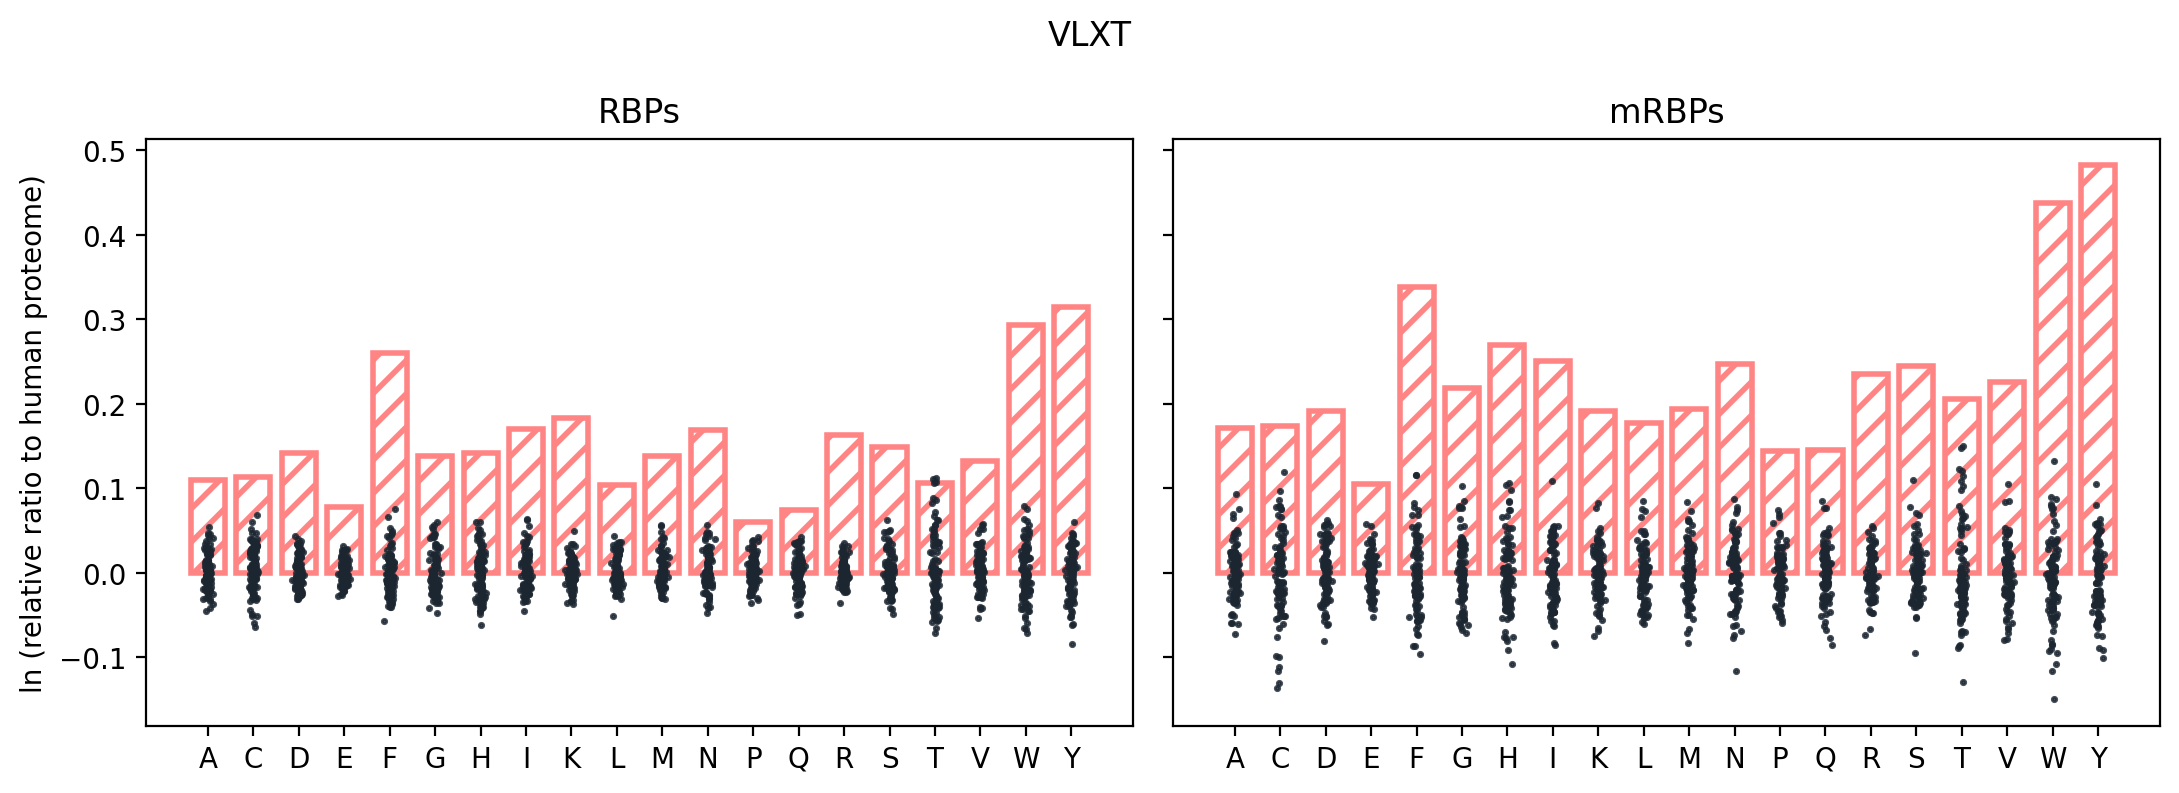

In [12]:
mpl.rcParams["hatch.linewidth"] = 2
f, (a0, a1) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11, 4), dpi=200)

X = np.arange(len(aa_sort))

noise = np.random.normal(0, 0.05, (output["rbp"]["human_sample"].shape))
for index, i in enumerate(output["rbp"]["human_sample"]):
    a0.scatter(X + noise[index], i, color=(0.105, 0.149, 0.192, 0.8), s=2.5, zorder=10)
a0.bar(X, output["rbp"]["population"][0], width=0.75, tick_label=aa_sort, zorder=0, color="white", hatch="//", linewidth=2, edgecolor="#ff8484",)
a0.set_title("RBPs")
a0.set_ylabel("ln (relative ratio to human proteome)")

noise = np.random.normal(0, 0.05, (output["mrbp"]["human_sample"].shape))
for index, i in enumerate(output["mrbp"]["human_sample"]):
    a1.scatter(X + noise[index], i, color=(0.105, 0.149, 0.192, 0.8), s=2.5, zorder=10)
a1.bar(X, output["mrbp"]["population"][0], width=0.75, tick_label=aa_sort, zorder=0, color="white", hatch="//", linewidth=2, edgecolor="#ff8484",)
a1.set_title("mRBPs")
# a1.set_ylim(-0.2, 0.6)

f.suptitle(algorithm)
f.tight_layout()

# Table s2~s5 output

In [13]:
rbp = aa_content(od_rbp_df)
mrbp = aa_content(od_mrbp_df)
human = aa_content(od_human_df)

In [14]:
df = pd.DataFrame()

df["aa"] = rbp['order'].keys()

df["rbp_order"] = rbp['order'].values()
df["rbp_disorder"] = rbp['disorder'].values()

df["mrbp_order"] = mrbp['order'].values()
df["mrbp_disorder"] = mrbp['disorder'].values()

df["human_order"] = human['order'].values()
df["human_disorder"] = human['disorder'].values()

df.to_excel(table_s2tos5_path/"{}.xlsx".format(algorithm))
df

,aa,rbp_order,rbp_disorder,mrbp_order,mrbp_disorder,human_order,human_disorder
0,A,33756,27753,15937,14705,474415,321897
1,C,12347,2659,5352,1241,220009,41333
2,D,27212,18477,13251,9794,349268,188768
3,E,31845,36203,15337,18483,409580,396968
4,F,25329,4882,12213,2585,362796,51625
5,G,32054,26374,15769,15087,452912,293467
6,H,15428,6539,6987,3574,220858,76954
7,I,26300,11065,12346,5835,369522,123116
8,K,34785,26352,16120,12382,417435,233546
9,L,54416,25921,24425,12994,802230,329184


# Table s6 output

In [15]:
df = pd.DataFrame()

df['random_1533_ave'] = np.mean(human_sample_for_rbp['ratio_matrix'],axis=0)
df['random_1533_std'] = np.std(human_sample_for_rbp['ratio_matrix'],axis=0)
df['random_1533_max'] = np.max(human_sample_for_rbp['ratio_matrix'],axis=0)
df['random_1533_min'] = np.min(human_sample_for_rbp['ratio_matrix'],axis=0)

df['random_688_ave'] = np.mean(human_sample_for_mrbp['ratio_matrix'],axis=0)
df['random_688_std'] = np.std(human_sample_for_mrbp['ratio_matrix'],axis=0)
df['random_688_max'] = np.max(human_sample_for_mrbp['ratio_matrix'],axis=0)
df['random_688_min'] = np.min(human_sample_for_mrbp['ratio_matrix'],axis=0)

df = round(df,2)

df.to_excel(table_s6_path/"{}.xlsx".format(algorithm))
df

,random_1533_ave,random_1533_std,random_1533_max,random_1533_min,random_688_ave,random_688_std,random_688_max,random_688_min
0,0.0,0.02,0.05,-0.04,-0.00,0.03,0.09,-0.07
1,0.0,0.03,0.07,-0.06,-0.00,0.05,0.12,-0.14
2,0.0,0.02,0.04,-0.03,0.00,0.03,0.06,-0.08
3,0.0,0.01,0.03,-0.03,-0.00,0.02,0.06,-0.05
4,0.0,0.02,0.07,-0.06,-0.00,0.04,0.12,-0.10
5,-0.0,0.02,0.06,-0.05,-0.00,0.04,0.10,-0.07
6,-0.0,0.03,0.06,-0.06,-0.00,0.04,0.11,-0.11
7,0.0,0.02,0.06,-0.05,-0.00,0.04,0.11,-0.09
8,0.0,0.02,0.05,-0.04,-0.00,0.03,0.08,-0.07
9,0.0,0.02,0.04,-0.05,-0.00,0.03,0.09,-0.06
